In [37]:
%reset

# 1. Imports

In [38]:
import mne
import time
import os
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import custom_modules.xdf_to_fif_converter as xtfc
import custom_modules.preprocessing_ptu as prep
import custom_modules.file_handling as  fh
import custom_modules.processing_ptu as proc
import custom_modules.classification_ptu as clas
import custom_modules.visualization_ptu as visu

import importlib
importlib.reload(xtfc)
importlib.reload(prep)
importlib.reload(fh)
importlib.reload(proc)
importlib.reload(clas)
importlib.reload(visu)

<module 'custom_modules.visualization_ptu' from 'C:\\Users\\peter\\Documents\\Code\\master-thesis\\03_analysis\\custom_modules\\visualization_ptu.py'>

# 2. Constants

In [39]:
data_path = 'D:/Diplomarbeit_data/eeg/'
subjects = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07' , 'A08', 'A09', 'A10']
trial_type_markers = ['LTR-s', 'LTR-l','RTL-s', 'RTL-l', 'TTB-s', 'TTB-l', 'BTT-s', 'BTT-l']

# Paths to interface files:
# path_cue_aligned_resampled = '2023_03_22_epoched_cue_aligned'
# path_movement_aligned_resampled = '2023_03_22_epoched_movement_aligned'
# path_cue_aligned_not_resampled = '2023_03_22_epoched_cue_aligned_not_resampled'
# path_movement_aligned_not_resampled = '2023_03_22_epoched_movement_aligned_not_resampled'

path_cue_aligned_resampled = '2023_05_24_epoched_cue_aligned'
path_movement_aligned_resampled = '2023_05_24_epoched_movement_aligned'
path_cue_aligned_not_resampled = '2023_05_24_epoched_cue_aligned_not_resampled'
path_movement_aligned_not_resampled = '2023_05_24_epoched_movement_aligned_not_resampled'

path_to_results = 'D:/Diplomarbeit_data/eeg/results'
path_to_figs = 'D:/Diplomarbeit_data/eeg/figs'

__spec__ = None # For multiprocessing
mne.set_log_level('WARNING') #'INFO' 'WARNING'

sns.set_context('paper')

## 2.1. Helper functions

In [194]:
def two_sample_permutation_test(pop1, pop2, n_perm=10000):
    from scipy.stats import ttest_ind, ttest_rel

    # Perform permutation test on the two populations:
    n1, n2 = len(pop1), len(pop2)
    combined = np.hstack((pop1, pop2))
    combined = combined.reshape((1,len(combined)))

    # Create a matrix with n_perm rows and permute the values of each row:
    values = np.repeat(combined, n_perm, axis=0)
    perm_vals = np.apply_along_axis(np.random.permutation, axis=1, arr=values)

    # Split values again:
    perm_pop1 = perm_vals[:,:n1]
    perm_pop2 = perm_vals[:,n1:]

    # Apply 2 sample t-test:
    _stat, _pval = ttest_ind(perm_pop1, perm_pop2, axis=1)
    _stat = np.abs(_stat)

    orig_stat, orig_p = ttest_ind(pop1, pop2) #ttest_rel(pop1, pop2) #
    # Sort stats:
    _stat.sort()
    print(_stat.shape)

    # Check how many values in stats are bigger than the original statistic
    stats_above = _stat >= np.abs(orig_stat)

    # Get the number of stats that are bigger than the original statistic:
    ids_above = stats_above.sum()

    # Get proporotion of idcs that are bigger than original statistic:
    pval = ids_above / n_perm
    return pval

def perm_helper(shorts_per_s, longs_per_s):
    res = []
    for i in range(shorts_per_s.shape[1]):
        res.append(two_sample_permutation_test(shorts_per_s[:,i], longs_per_s[:,i]))
        if i % 10 == 0:
            print(i)

    return res

In [223]:
def one_sample_permutation_test(diff_pop, n_perm=10000):
    from scipy.stats import ttest_1samp

    # Perform permutation test on the two populations:
    n = len(diff_pop)
    sign_list = [-1, 1]

    # Create a random 1, -1 matrix with size len(vals) x n_perm
    signs = np.random.choice(sign_list, size=(len(diff_pop), n_perm))

    # Get absolute values of the difference population:
    abs_vals = np.array(np.abs(diff_pop))
    abs_vals = np.reshape(abs_vals, (len(abs_vals), 1))
    vals_rep = np.repeat(abs_vals, n_perm, axis=1)
    perm_vals = vals_rep * signs

    # Apply 1 sample t-test:
    _stat, _pval = ttest_1samp(perm_vals, axis=0, popmean=0)
    _stat = np.abs(_stat)

    orig_stat, orig_p = ttest_1samp(diff_pop, popmean=0) #ttest_rel(pop1, pop2) #
    # Sort stats:
    _stat.sort()
    # print(_stat.shape, end='\r')
    # Check how many values in stats are bigger than the original statistic
    stats_above = _stat >= np.abs(orig_stat)

    # Get the number of stats that are bigger than the original statistic:
    ids_above = stats_above.sum()

    # Get proporotion of idcs that are bigger than original statistic:
    pval = ids_above / n_perm

    return pval

# 3. Temporal results

## 3.1. Timings overall

In [305]:
path_to_results = 'D:/Diplomarbeit_data/eeg/results'
path_to_figs = 'D:/Diplomarbeit_data/eeg/figs'

# name is like timings-cue/release/touch_sbj_alignment.npy
alignment = 'movement-aligned' # 'movement-aligned'


# Load timing results:
timings_cue = [np.load(f'{path_to_results}/timings-cue_{sbj}_{alignment}.npy') for sbj in subjects]
timings_release = [np.load(f'{path_to_results}/timings-release_{sbj}_{alignment}.npy') for sbj in subjects]
timings_touch = [np.load(f'{path_to_results}/timings-touch_{sbj}_{alignment}.npy') for sbj in subjects]

# Add all timings to np arary:
timings_cue_np = np.hstack(timings_cue)
timings_release_np = np.hstack(timings_release)
timings_touch_np = np.hstack(timings_touch)

# Align release/touch to the cue and difference between release touch:
diff_cue_release = timings_release_np - timings_cue_np
diff_cue_touch = timings_touch_np - timings_cue_np
diff_release_touch = timings_touch_np - timings_release_np



In [306]:
def _gauss(n=55,b=1):
    r = range(-int(n/2),int(n/2)+1)
    return [np.exp(-float(x)**2/(2*b**2)) for x in r]

# Create smoothed timings for plotting in grand averages:
# Load sample epoch:
# Load example epo for channels list:
epochs = mne.read_epochs(f'{path_to_results}/sample-epoch_{alignment}_epo.fif', preload=True)

# Get cue, movement onset, movement stop histograms:
if alignment == 'cue-aligned':
    # Make "histogram" of difference between movement onset and cue-alignment:
    bins=np.arange(epochs.tmin, epochs.tmax, 1/epochs.info['sfreq'])
    diff_cue_release += 2.0
    diff_cue_touch += 2.0

    hist_cue_release = np.histogram(diff_cue_release, bins=bins, range=None)
    hist_cue_touch = np.histogram(diff_cue_touch, bins=bins, range=None)

    l_kernel = 55
    kernel = _gauss(n=l_kernel, b=0.1*epochs.info['sfreq'])

    smoothed_cue_release = np.convolve(hist_cue_release[0], kernel, 'same')
    smoothed_cue_touch = np.convolve(hist_cue_touch[0], kernel, 'same')

    smoothed_cue_release = (smoothed_cue_release - smoothed_cue_release.min()) / (smoothed_cue_release.max() - smoothed_cue_release.min())
    smoothed_cue_touch = (smoothed_cue_touch - smoothed_cue_touch.min()) / (smoothed_cue_touch.max() - smoothed_cue_touch.min())


if alignment == 'movement-aligned':
    # Make "histogram" of difference between movement onset and cue-alignment:
    bins=np.arange(epochs.tmin, epochs.tmax, 1/epochs.info['sfreq'])
    diffs_cue_release = np.array(diff_cue_release) * (-1.0)
    diffs_release_touch = np.array(diff_release_touch)

    hist_cue_release = np.histogram(diffs_cue_release, bins=bins, range=None)
    hist_release_touch = np.histogram(diffs_release_touch, bins=bins, range=None)

    l_kernel = 55
    kernel = _gauss(n=l_kernel, b=0.1*epochs.info['sfreq'])

    smoothed_cue_release = np.convolve(hist_cue_release[0], kernel, 'same')
    smoothed_release_touch = np.convolve(hist_release_touch[0], kernel, 'same')

    smoothed_cue_release = (smoothed_cue_release - smoothed_cue_release.min()) / (smoothed_cue_release.max() - smoothed_cue_release.min())
    smoothed_release_touch = (smoothed_release_touch - smoothed_release_touch.min()) / (smoothed_release_touch.max() - smoothed_release_touch.min())

## 3.2. Timings short v long

In [224]:
path_to_results = 'D:/Diplomarbeit_data/eeg/results'

# name is like timings-cue/release/touch_sbj_alignment.npy
alignment = 'cue-aligned' # 'movement-aligned'

# Load timing results:
timings_cue_l = [np.load(f'{path_to_results}/timings-cue-l_{sbj}_{alignment}.npy') for sbj in subjects]
timings_release_l = [np.load(f'{path_to_results}/timings-release-l_{sbj}_{alignment}.npy') for sbj in subjects]
timings_touch_l = [np.load(f'{path_to_results}/timings-touch-l_{sbj}_{alignment}.npy') for sbj in subjects]

timings_cue_s = [np.load(f'{path_to_results}/timings-cue-s_{sbj}_{alignment}.npy') for sbj in subjects]
timings_release_s = [np.load(f'{path_to_results}/timings-release-s_{sbj}_{alignment}.npy') for sbj in subjects]
timings_touch_s = [np.load(f'{path_to_results}/timings-touch-s_{sbj}_{alignment}.npy') for sbj in subjects]

# Add all timings to np arary:
timings_cue_l_np = np.hstack(timings_cue_l)
timings_release_l_np = np.hstack(timings_release_l)
timings_touch_l_np = np.hstack(timings_touch_l)

timings_cue_s_np = np.hstack(timings_cue_s)
timings_release_s_np = np.hstack(timings_release_s)
timings_touch_s_np = np.hstack(timings_touch_s)

# Align release/touch to the cue and difference between release touch:
diff_cue_release_l = timings_release_l_np - timings_cue_l_np
diff_cue_touch_l = timings_touch_l_np - timings_cue_l_np
diff_release_touch_l = timings_touch_l_np - timings_release_l_np

diff_cue_release_s = timings_release_s_np - timings_cue_s_np
diff_cue_touch_s = timings_touch_s_np - timings_cue_s_np
diff_release_touch_s = timings_touch_s_np - timings_release_s_np

# Get mean for each subject:
mean_cue_l = np.array([np.mean(entry) for entry in timings_cue_l])
mean_release_l = np.array([np.mean(entry) for entry in timings_release_l])
mean_touch_l = np.array([np.mean(entry) for entry in timings_touch_l])

mean_cue_s = np.array([np.mean(entry) for entry in timings_cue_s])
mean_release_s = np.array([np.mean(entry) for entry in timings_release_s])
mean_touch_s = np.array([np.mean(entry) for entry in timings_touch_s])

mean_cue_release_l = mean_release_l - mean_cue_l
mean_cue_touch_l = mean_touch_l - mean_cue_l
mean_release_touch_l = mean_touch_l - mean_release_l

mean_cue_release_s = mean_release_s - mean_cue_s
mean_cue_touch_s = mean_touch_s - mean_cue_s
mean_release_touch_s = mean_touch_s - mean_release_s

Mean short: 1.3978504122770965
STD short: 0.6984796763617613
Mean long: 1.3672009195999297
STD long: 0.6810952434206587
-----------------
Mean short: 2.177200914407531
STD short: 0.7303325495720485
Mean long: 2.2748453132437207
STD long: 0.7562084529976855
-----------------
Mean short: 0.7793505021304347
STD short: 0.3946001251262587
Mean long: 0.907644393643791
STD long: 0.3690661123693939
(10000,)
pval cue-release: 0.2003
(10000,)
pval cue-touch: 0.0002
(10000,)
pval release-touch: 0.0


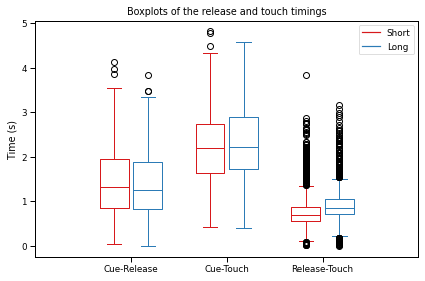

In [225]:
# create 2 - sample a 3-Dim array, that measures
# the summer and winter rain fall amount
short = [diff_cue_release_s, diff_cue_touch_s, diff_release_touch_s]
long = [diff_cue_release_l, diff_cue_touch_l, diff_release_touch_l]

# the list named ticks, summarizes or groups
# the summer and winter rainfall as low, mid
# and high
ticks = ['Cue-Release', 'Cue-Touch', 'Release-Touch']

short_plot = plt.boxplot(short, positions=np.array(np.arange(len(short)))*2.0-0.35, widths=0.6)
long_plot = plt.boxplot(long, positions=np.array(np.arange(len(long)))*2.0+0.35, widths=0.6)

def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)

    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend()


# setting colors for each groups
define_box_properties(short_plot, '#D7191C', 'Short')
define_box_properties(long_plot, '#2C7BB6', 'Long')

# set the x label values
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)

# set the limit for x axis
plt.xlim(-2, len(ticks)*2)

# set the limit for y axis
# plt.ylim(0, 50)
plt.ylabel('Time (s)')

# set the title
plt.title('Boxplots of the release and touch timings')

plt.tight_layout()
plt.savefig(f'{path_to_figs}/boxplot_timings.png', bbox_inches='tight', dpi=300)

# Report metrics:
print(f'Mean short: {np.mean(diff_cue_release_s)}')
print(f'STD short: {np.std(diff_cue_release_s)}')
print(f'Mean long: {np.mean(diff_cue_release_l)}')
print(f'STD long: {np.std(diff_cue_release_l)}')
print('-----------------')
print(f'Mean short: {np.mean(diff_cue_touch_s)}')
print(f'STD short: {np.std(diff_cue_touch_s)}')
print(f'Mean long: {np.mean(diff_cue_touch_l)}')
print(f'STD long: {np.std(diff_cue_touch_l)}')
print('-----------------')
print(f'Mean short: {np.mean(diff_release_touch_s)}')
print(f'STD short: {np.std(diff_release_touch_s)}')
print(f'Mean long: {np.mean(diff_release_touch_l)}')
print(f'STD long: {np.std(diff_release_touch_l)}')

# Perform permutation test on the two populations:
print(f'pval cue-release: {two_sample_permutation_test(diff_cue_release_s, diff_cue_release_l)}')
print(f'pval cue-touch: {two_sample_permutation_test(diff_cue_touch_s, diff_cue_touch_l)}')
print(f'pval release-touch: {two_sample_permutation_test(diff_release_touch_s, diff_release_touch_l)}')

Mean short: 1.4117481649938781
STD short: 0.4131514509805501
Mean long: 1.3806597268377119
STD long: 0.41903766086054883
-----------------
Mean short: 2.195187881205675
STD short: 0.549323523757525
Mean long: 2.291765010906056
STD long: 0.568807701592018
-----------------
Mean short: 0.7834397162117966
STD short: 0.15600782037726585
Mean long: 0.9111052840683442
STD long: 0.17188963640989444
(10000,)
pval cue-release: 0.8678
(10000,)
pval cue-touch: 0.7202
(10000,)
pval release-touch: 0.1216
pval cue-release: 0.0972
pval cue-touch: 0.0038
pval release-touch: 0.0021
pval cue-release: 0.10546875
pval cue-touch: 0.00390625
pval release-touch: 0.001953125


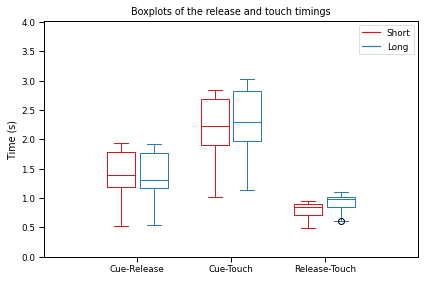

In [226]:
# create 2 - sample a 3-Dim array, that measures
# the summer and winter rain fall amount
short = [mean_cue_release_s, mean_cue_touch_s, mean_release_touch_s]
long = [mean_cue_release_l, mean_cue_touch_l, mean_release_touch_l]

# the list named ticks, summarizes or groups
# the summer and winter rainfall as low, mid
# and high
ticks = ['Cue-Release', 'Cue-Touch', 'Release-Touch']

short_plot = plt.boxplot(short, positions=np.array(np.arange(len(short)))*2.0-0.35, widths=0.6)
long_plot = plt.boxplot(long, positions=np.array(np.arange(len(long)))*2.0+0.35, widths=0.6)

def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)

    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend()


# setting colors for each groups
define_box_properties(short_plot, '#D7191C', 'Short')
define_box_properties(long_plot, '#2C7BB6', 'Long')

# set the x label values
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)

# set the limit for x axis
plt.xlim(-2, len(ticks)*2)

plt.ylabel('Time (s)')
# set the limit for y axis
plt.ylim(0, np.max(long) + 1.0)

# Add p values:
#
# pos_shorts = np.array(np.arange(len(short)))*2.0-0.35
# pos_longs = np.array(np.arange(len(short)))*2.0+0.35
# y, h, col = max(map(max, long)) + 2, 2, 'k'
# plt.plot([pos_shorts[0], pos_shorts[0], pos_longs[0], pos_longs[0]], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((pos_shorts[0]+pos_longs[0])*.5, y+h, "ns", ha='center', va='bottom', color=col)

# set the title
plt.title('Boxplots of the release and touch timings')
plt.tight_layout()
plt.savefig(f'{path_to_figs}/boxplot_timings_mean.png', bbox_inches='tight', dpi=300)
#plt.savefig(f'{path_to_figs}/boxplot_timings_mean.svg', bbox_inches='tight')

# Report metrics:
print(f'Mean short: {np.mean(mean_cue_release_s)}')
print(f'STD short: {np.std(mean_cue_release_s)}')
print(f'Mean long: {np.mean(mean_cue_release_l)}')
print(f'STD long: {np.std(mean_cue_release_l)}')
print('-----------------')
print(f'Mean short: {np.mean(mean_cue_touch_s)}')
print(f'STD short: {np.std(mean_cue_touch_s)}')
print(f'Mean long: {np.mean(mean_cue_touch_l)}')
print(f'STD long: {np.std(mean_cue_touch_l)}')
print('-----------------')
print(f'Mean short: {np.mean(mean_release_touch_s)}')
print(f'STD short: {np.std(mean_release_touch_s)}')
print(f'Mean long: {np.mean(mean_release_touch_l)}')
print(f'STD long: {np.std(mean_release_touch_l)}')

# Perform permutation test on the two populations:
print(f'pval cue-release: {two_sample_permutation_test(mean_cue_release_s, mean_cue_release_l)}')
print(f'pval cue-touch: {two_sample_permutation_test(mean_cue_touch_s, mean_cue_touch_l)}')
print(f'pval release-touch: {two_sample_permutation_test(mean_release_touch_s, mean_release_touch_l)}')
# Perform permutation test on the two populations:
print(f'pval cue-release: {one_sample_permutation_test(mean_cue_release_s-mean_cue_release_l)}')
print(f'pval cue-touch: {one_sample_permutation_test(mean_cue_touch_s-mean_cue_touch_l)}')
print(f'pval release-touch: {one_sample_permutation_test(mean_release_touch_s-mean_release_touch_l)}')

from scipy.stats import wilcoxon
print(f'pval cue-release: {wilcoxon(mean_cue_release_s-mean_cue_release_l).pvalue}')
print(f'pval cue-touch: {wilcoxon(mean_cue_touch_s-mean_cue_touch_l).pvalue}')
print(f'pval release-touch: {wilcoxon(mean_release_touch_s, mean_release_touch_l).pvalue}')


## 3.3. Grand averages

100%|██████████| 1201/1201 [00:13<00:00, 91.49it/s] 


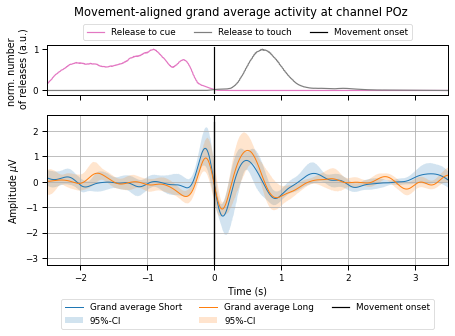

100%|██████████| 1201/1201 [00:09<00:00, 120.90it/s]


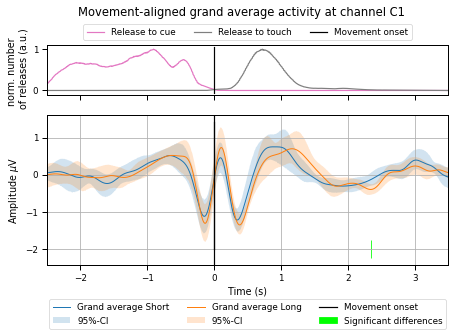

In [308]:
path_to_results = 'D:/Diplomarbeit_data/eeg/results'

# name is like grand-avg_alignment_condition.npy
# alignment = 'cue-aligned' # 'movement-aligned'

# Load grand averages + confidence intervals:
grand_avg_all_cond = np.load(f'{path_to_results}/grand-avg_{alignment}_All-conditions.npy')
lowers_all_cond = np.load(f'{path_to_results}/grand-avg-lowers_{alignment}_All-conditions.npy')
uppers_all_cond = np.load(f'{path_to_results}/grand-avg-uppers_{alignment}_All-conditions.npy')
grand_avg_short = np.load(f'{path_to_results}/grand-avg_{alignment}_Short-dist.npy')
lowers_short = np.load(f'{path_to_results}/grand-avg-lowers_{alignment}_Short-dist.npy')
uppers_short = np.load(f'{path_to_results}/grand-avg-uppers_{alignment}_Short-dist.npy')
grand_avg_long = np.load(f'{path_to_results}/grand-avg_{alignment}_Long-dist.npy')
lowers_long = np.load(f'{path_to_results}/grand-avg-lowers_{alignment}_Long-dist.npy')
uppers_long = np.load(f'{path_to_results}/grand-avg-uppers_{alignment}_Long-dist.npy')

sbj_short_avgs = [np.load(f'{path_to_results}/sbj-grand-avg_{sbj}_{alignment}_Short-dist.npy') for sbj in subjects]
sbj_long_avgs = [np.load(f'{path_to_results}/sbj-grand-avg_{sbj}_{alignment}_Long-dist.npy') for sbj in subjects]

# Load example epo for channels list:
epochs = mne.read_epochs(f'{path_to_results}/sample-epoch_{alignment}_epo.fif', preload=True)

# Get channel list:
channels = epochs.ch_names

ch_of_interest = 'C1'
ch_idx = channels.index(ch_of_interest)

# Test conditions with permutation t-test:
shorts_per_subject = [sbj_short_avgs[i][ch_idx,:] for i in range(len(subjects))]
shorts_per_subject = np.vstack(shorts_per_subject)
longs_per_subject = [sbj_long_avgs[i][ch_idx,:] for i in range(len(subjects))]
longs_per_subject = np.vstack(longs_per_subject)


pvals = np.ones((shorts_per_subject.shape[1]))
from tqdm import tqdm
for ts in tqdm(range(shorts_per_subject.shape[1])):
    # res = wilcoxon(shorts_per_subject[:,ts], longs_per_subject[:,ts])
    # pvals[ts] = res.pvalue
    # pvals[ts] = two_sample_permutation_test(shorts_per_subject[:,ts], longs_per_subject[:,ts])
    pvals[ts] = one_sample_permutation_test(shorts_per_subject[:,ts] - longs_per_subject[:,ts])
    # if ts % 100 == 0:
    #     print(ts)


# Create binary p-val array:
p_bin = pvals < 0.05/shorts_per_subject.shape[1]
# Get ids where p_bin is true:
p_ids = np.where(p_bin==True)

# Visualize grand average:
x = np.arange(epochs.tmin, epochs.tmax+1/epochs.info['sfreq'], 1/epochs.info['sfreq'])

fig, ax = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [1, 3]}, sharex='col', figsize=(7.2,4.05))
ax[1].plot(x, grand_avg_short[ch_idx, :]*1e6, linewidth=1)
ax[1].fill_between(x, lowers_short[ch_idx, :]*1e6, uppers_short[ch_idx, :]*1e6, alpha=0.2)

ax[1].plot(x, grand_avg_long[ch_idx, :]*1e6, linewidth=1)
ax[1].fill_between(x, lowers_long[ch_idx, :]*1e6, uppers_long[ch_idx, :]*1e6, alpha=0.2)


y = int(ax[1].get_ylim()[0] - 1)
legend_text = ['Grand average Short', '95%-CI', 'Grand average Long', '95%-CI']
if alignment == 'cue-aligned':
    ax[1].plot([2.0, 2.0], [y, ax[1].get_ylim()[1]], 'black')
    legend_text.append('Cue presentation')
else:
    ax[1].plot([0.0, 0.0], [y, ax[1].get_ylim()[1]], 'black')
    legend_text.append('Movement onset')


in_draw = False
never_draw = True
for i in range(len(p_bin)):
    if p_bin[i] and not in_draw:
        never_draw = False
        in_draw = True
        start_x = x[i]
    if not p_bin[i] and in_draw:
        in_draw = False
        ax[1].fill_between([start_x, x[i-1]], y-0.25, y+0.25, color='lime')
if in_draw:
    ax[1].fill_between([start_x, x[i]], y-0.25, y+0.25, color='lime')

if not never_draw:
    legend_text.append('Significant differences')

ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel(r'Amplitude $\mu$V')
ax[1].set_xlim([x[0], x[-1]])
ax[1].grid(True, which='both')

if alignment == 'cue-aligned':
    ax[0].plot(x[1:-1], smoothed_cue_release, color='C6')
    ax[0].plot(x[1:-1], smoothed_cue_touch, color='C7')
    ax[0].plot([2.0, 2.0], ax[0].get_ylim(), 'black')
    ax[0].legend(['Cue to release', 'Cue to touch', 'Cue presentation'], loc='upper center', bbox_to_anchor=(0.5, 1.5), fancybox=True, ncol=3)

    # Re-draw cue onset to correct ylims:
    ax[1].set_ylim(ax[1].get_ylim())
    ax[1].plot([2.0, 2.0], ax[1].get_ylim(), 'black')

if alignment == 'movement-aligned':
    ax[0].plot(x[1:-1], smoothed_cue_release, color='C6')
    ax[0].plot(x[1:-1], smoothed_release_touch, color='C7')
    ax[0].plot([0.0, 0.0], ax[0].get_ylim(), 'black')
    ax[0].legend(['Release to cue', 'Release to touch', 'Movement onset'], loc='upper center', bbox_to_anchor=(0.5, 1.5), fancybox=True, ncol=3)

    # Re-draw cue onset to correct ylims:
    ax[1].set_ylim(ax[1].get_ylim())
    ax[1].plot([0.0, 0.0], ax[1].get_ylim(), 'black')

ax[0].set_xlim([x[0], x[-1]])
# ax[0].set(frame_on=False)
# ax[0].get_yaxis().set_visible(False)
ax[0].grid(True, which='minor')
ax[0].set_ylabel('norm. number \n of releases (a.u.)', labelpad=4.0)

ax[1].legend(legend_text, loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, ncol=3)

if alignment == 'cue-aligned':
    fig.suptitle(f'Cue-aligned grand average activity at channel {ch_of_interest}', y=1.01)
else:
    fig.suptitle(f'Movement-aligned grand average activity at channel {ch_of_interest}', y=1.01)
plt.savefig(f'{path_to_figs}/grand_average_{ch_of_interest}_{alignment}.png', bbox_inches='tight', dpi=300)
#
# timings_cue_l = [np.load(f'{path_to_results}/timings-cue-l_{sbj}_{alignment}.npy') for sbj in subjects]
# timings_release_l = [np.load(f'{path_to_results}/timings-release-l_{sbj}_{alignment}.npy') for sbj in subjects]
# timings_touch_l = [np.load(f'{path_to_results}/timings-touch-l_{sbj}_{alignment}.npy') for sbj in subjects]

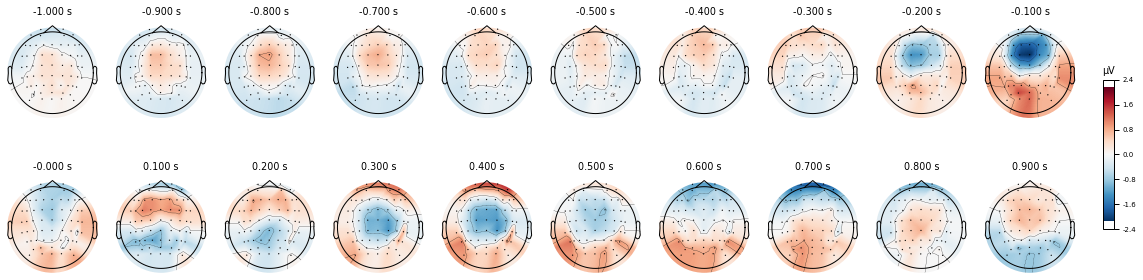

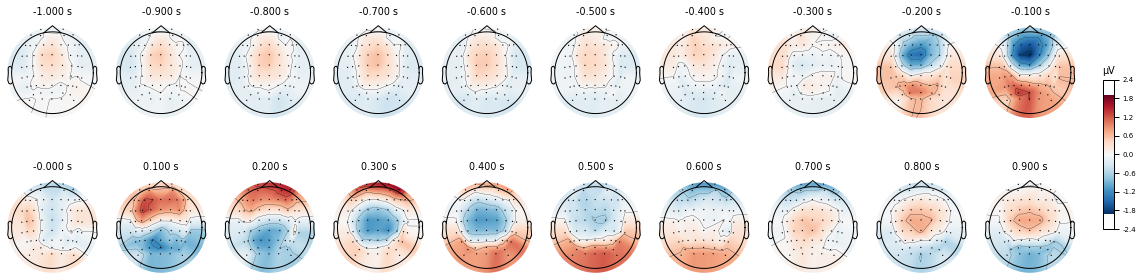

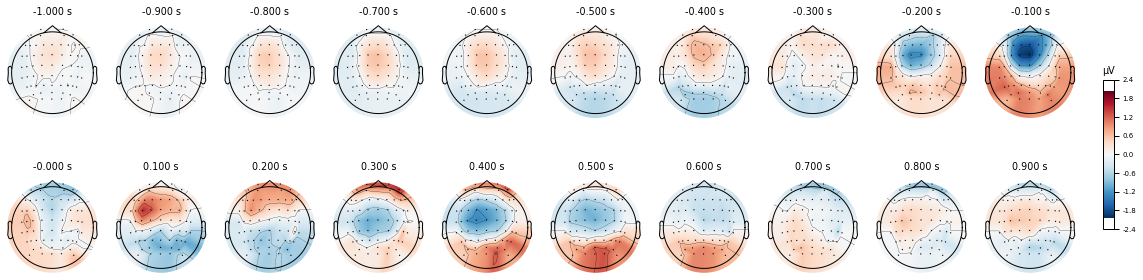

In [253]:
# Topoplots:
# Load all grand averages:
grand_avg_all_cond = np.load(f'{path_to_results}/grand-avg_{alignment}_All-conditions.npy')
grand_avg_short = np.load(f'{path_to_results}/grand-avg_{alignment}_Short-dist.npy')
grand_avg_long = np.load(f'{path_to_results}/grand-avg_{alignment}_Long-dist.npy')

# Load example epo for channels list:
epochs = mne.read_epochs(f'{path_to_results}/sample-epoch_{alignment}_epo.fif', preload=True)

def create_topoplot(ga, align, epo):
    # Add grand average into mne structure:
    n_chan, n_times = epo.info['nchan'], epo.times.shape[0]
    grand_avg_extended = ga.reshape((1, n_chan, n_times))
    grand_avg_epochs = mne.EpochsArray(grand_avg_extended, epochs.info, tmin=epochs.tmin)

    if align == 'cue-aligned':
        times = np.arange(2.0, 4.0, 0.1)
    elif align == 'movement-aligned':
        times = np.arange(-1.0, 1.0, .1)

    return grand_avg_epochs.average().plot_topomap(times, ch_type='eeg', ncols=10,
                                                  nrows='auto', image_interp='linear')#, scalings=dict(eeg=1e-6))#, units='a.u.', vlim=(0, 1))

fig = create_topoplot(grand_avg_all_cond, alignment, epochs)
fig.savefig(f'{path_to_figs}/grand_average_topo_{alignment}_all-conditions.png', bbox_inches='tight', dpi=300)

fig = create_topoplot(grand_avg_short, alignment, epochs)
fig.savefig(f'{path_to_figs}/grand_average_topo_{alignment}_short.png', bbox_inches='tight', dpi=300)

fig = create_topoplot(grand_avg_long, alignment, epochs)
fig.savefig(f'{path_to_figs}/grand_average_topo_{alignment}_long.png', bbox_inches='tight', dpi=300)

1201

# 4. Classification results

# 5. GLM results

In [ ]:
importlib.reload(visu)

src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='results', dst_fldr='figs3hz')

avg = visu.glm_significant_topo(src_path, dst_path, subjects, alignment='cue-aligned', p_crit=.05, shrink=True, one_sample=True)

avg = visu.glm_significant_topo(src_path, dst_path, subjects, alignment='cue-aligned', p_crit=.05, shrink=True, one_sample=False)


avg = visu.glm_significant_topo(src_path, dst_path, subjects, alignment='movement-aligned', p_crit=.05, shrink=True, one_sample=True)

avg = visu.glm_significant_topo(src_path, dst_path, subjects, alignment='movement-aligned', p_crit=.05, shrink=True, one_sample=False)




In [ ]:
importlib.reload(visu)

src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='results', dst_fldr='figs3hz')

avg = visu.condition_topos(src_path, dst_path, subjects, alignment='cue-aligned', shrink=True)

In [ ]:
pvals = np.load('D:/Diplomarbeit_data/eeg/results/regr-coeff-p-vals_cue-aligned_no-shrink.npy')


In [ ]:
reg_coeff = np.load('D:/Diplomarbeit_data/eeg/results/regr-coeff_A03_cue-aligned_no-shrink.npy')

import matplotlib.pyplot as plt

print(reg_coeff.shape)
for cond in range(reg_coeff.shape[0]-1):
    print(cond)
    plt.plot(reg_coeff[cond,10,:])
plt.show()

In [ ]:
s_intercept = np.ones((1,360))

temp = np.concatenate([s_intercept.squeeze(), s_intercept.squeeze()])

# s_intercept = (s_intercept - s_intercept.mean())/s_intercept.std()

In [ ]:
X = np.array([[1,2,3],
              [4,5,6]])

Y = np.array([[2,4],
              [8,10],
              [14,16]])

In [ ]:
cx = np.cov(X.T)
cy = np.cov(Y.T)

In [ ]:
cx.dot(cy)

In [ ]:
# Load p_vals of glm:
p_vals = np.load(f'{src_path}/two-sample-p-vals_cue-aligned_shrink.npy')

# Get binary mask for p_vals that are smaller than p_crit
p_crit = 0.05
p_bin = p_vals < p_crit
temp_p = p_vals[:,2,:]
import matplotlib.pyplot as plt
t = np.arange(0,1200,10)
plt.imshow(p_bin[:,0,t])

# 6. Parking lot

In [ ]:
# Box plots:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title('Difference between release of the start handle and touch of the target handle')
ax.boxplot([diff_release_touch_s, diff_release_touch_l])
ax.set_ylabel('Time (s)')
ax.set_xticks([1, 2], ['short', 'long'])
plt.tight_layout()
fig.savefig(f'{path_to_figs}/boxplot_cue-aligned_cue-release.png', bbox_inches='tight', dpi=300)

In [ ]:
# Box plots:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title('Difference between release of start handle and touch of the target handle')
ax.boxplot([diff_release_touch_s, diff_release_touch_l])
ax.set_ylabel('Time (s)')
ax.set_xticks([1, 2], ['short', 'long'])
plt.tight_layout()
fig.savefig(f'{path_to_figs}/boxplot_cue-aligned_release-touch.png', bbox_inches='tight', dpi=300)

# Report metrics:
print(f'Mean short: {np.mean(diff_release_touch_s)}')
print(f'STD short: {np.std(diff_release_touch_s)}')
print(f'Mean long: {np.mean(diff_release_touch_l)}')
print(f'STD long: {np.std(diff_release_touch_l)}')

# Perform permutation test on the two populations:
print(f'pval of two sample perm test: {two_sample_permutation_test(diff_release_touch_s, diff_release_touch_l)}')

In [ ]:
# Box plots:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title('Difference between cue presentation and touch of the target handle')
ax.boxplot([diff_cue_touch_s, diff_cue_touch_l])
ax.set_ylabel('Time (s)')
ax.set_xticks([1, 2], ['short', 'long'])
plt.tight_layout()
fig.savefig(f'{path_to_figs}/boxplot_cue-aligned_cue-touch.png', bbox_inches='tight', dpi=300)

# Report metrics:
print(f'Mean short: {np.mean(diff_cue_touch_s)}')
print(f'STD short: {np.std(diff_cue_touch_s)}')
print(f'Mean long: {np.mean(diff_cue_touch_l)}')
print(f'STD long: {np.std(diff_cue_touch_l)}')

# Perform permutation test on the two populations:
print(f'pval of two sample perm test: {two_sample_permutation_test(diff_cue_touch_s, diff_cue_touch_l)}')


In [ ]:
# Box plots:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title('Difference between cue presentation and release of the start handle')
ax.boxplot([diff_cue_release_s, diff_cue_release_l])
ax.set_ylabel('Time (s)')
ax.set_xticks([1, 2], ['short', 'long'])
plt.tight_layout()
fig.savefig(f'{path_to_figs}/boxplot_cue-aligned_cue-release.png', bbox_inches='tight', dpi=300)

# Report metrics:
print(f'Mean short: {np.mean(diff_cue_release_s)}')
print(f'STD short: {np.std(diff_cue_release_s)}')
print(f'Mean long: {np.mean(diff_cue_release_l)}')
print(f'STD long: {np.std(diff_cue_release_l)}')

# Perform permutation test on the two populations:
print(f'pval of two sample perm test: {two_sample_permutation_test(diff_cue_release_s, diff_cue_release_l)}')